# Ahmed Mohamed Gaber 2203173 - Data preprocessing - Fuzzy
# Hazem Ahmed Abdelfatah 2203175 - Visualization - KMedoids 
# Eiad Tarek Ali 2203176 - Data preprocessing - Hierarchical 
# Moataz Ali Ramadan 2203177 - Visualization - Fuzzy 
# Youssef Salah Mostafa 22010442 - KMedoids - Technique Evaluation and insights

# Problem Definition

As people go on their every day lives, they seek means of transportation from one place to another, taxis are a popular mean amongst them, this dataset is concerned with taxi fare prices in relation to other aspects that could possibly affect it.

In this project, we aim to exclude the features with the most correlation with the fare price, and study patterns and annomalies from the clustering results.

## Importing needed libraries

In [1]:
!pip install -q gap_stat

In [2]:
!pip install -q scikit-learn-extra

In [3]:
!pip install -q scikit-fuzzy

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn_extra.cluster import KMedoids
import numpy as np
import skfuzzy as fuzzy
from skfuzzy import control as fuzz
# To remove unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [5]:
# Importing data
df = pd.read_csv('train.csv')
# dropping derived column
df.drop("total_fare",axis=1,inplace=True)
df

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,surge_applied
0,748.0,2.75,1.0,75.00,24,6.300,0
1,1187.0,3.43,1.0,105.00,24,13.200,0
2,730.0,3.12,1.0,71.25,0,26.625,1
3,671.0,5.63,3.0,90.00,0,9.750,0
4,329.0,2.09,1.0,45.00,12,13.200,0
...,...,...,...,...,...,...,...
209668,1617.0,8.42,1.0,150.00,47,5.800,0
209669,438.0,1.29,1.0,48.75,12,34.575,1
209670,571.0,2.82,1.0,63.75,0,6.000,0
209671,491.0,2.16,1.0,56.25,0,13.500,0


In [6]:
# Showing information about each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209673 entries, 0 to 209672
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   trip_duration       209673 non-null  float64
 1   distance_traveled   209673 non-null  float64
 2   num_of_passengers   209673 non-null  float64
 3   fare                209673 non-null  float64
 4   tip                 209673 non-null  int64  
 5   miscellaneous_fees  209673 non-null  float64
 6   surge_applied       209673 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 11.2 MB


## Data Pre-Processing

### Checking for nulls and handling them

In [7]:
# Checking null count
df.isnull().sum()

trip_duration         0
distance_traveled     0
num_of_passengers     0
fare                  0
tip                   0
miscellaneous_fees    0
surge_applied         0
dtype: int64

### Checking for duplicates and handling them

In [8]:
# Checking for duplicates
df.duplicated().sum()

4325

In [9]:
# Remove duplicate rows and assign the result to cdf and resetting index
cdf = df.drop_duplicates().reset_index(drop=True)
cdf

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,surge_applied
0,748.0,2.75,1.0,75.00,24,6.300,0
1,1187.0,3.43,1.0,105.00,24,13.200,0
2,730.0,3.12,1.0,71.25,0,26.625,1
3,671.0,5.63,3.0,90.00,0,9.750,0
4,329.0,2.09,1.0,45.00,12,13.200,0
...,...,...,...,...,...,...,...
205343,1617.0,8.42,1.0,150.00,47,5.800,0
205344,438.0,1.29,1.0,48.75,12,34.575,1
205345,571.0,2.82,1.0,63.75,0,6.000,0
205346,491.0,2.16,1.0,56.25,0,13.500,0


### Checking for outliers and handling them

In [10]:
# Iterate over each column in the DataFrame
for col in cdf.columns:

    # Calculate the Z-scores for each value in the column
    z_scores = np.abs((cdf[col] - cdf[col].mean()) / cdf[col].std())

    # Identify values in the column that have a Z-score greater than 3 (outliers)
    column_outliers = cdf[col][z_scores > 3]
    print(f"Number of outliers in {col}: {len(column_outliers)}")

    # Drop rows with outlier values from the DataFrame
    cdf.drop(column_outliers.index, axis=0, inplace=True)

# Reset the index of the DataFrame after dropping rows
cdf = cdf.reset_index(drop=True)

Number of outliers in trip_duration: 893
Number of outliers in distance_traveled: 2
Number of outliers in num_of_passengers: 8101
Number of outliers in fare: 3576
Number of outliers in tip: 1807
Number of outliers in miscellaneous_fees: 3001
Number of outliers in surge_applied: 0


### Making a copy of the original dataframe before scaling to save the final results to

In [11]:
final_df = cdf.copy()
final_df

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,surge_applied
0,748.0,2.75,1.0,75.00,24,6.300,0
1,1187.0,3.43,1.0,105.00,24,13.200,0
2,730.0,3.12,1.0,71.25,0,26.625,1
3,671.0,5.63,3.0,90.00,0,9.750,0
4,329.0,2.09,1.0,45.00,12,13.200,0
...,...,...,...,...,...,...,...
187963,1617.0,8.42,1.0,150.00,47,5.800,0
187964,438.0,1.29,1.0,48.75,12,34.575,1
187965,571.0,2.82,1.0,63.75,0,6.000,0
187966,491.0,2.16,1.0,56.25,0,13.500,0


### Scaling the dataset

In [12]:
# Initializing MinMaxScaler
scaler = MinMaxScaler()

# Scale the data
cdf[cdf.columns] = scaler.fit_transform(cdf[cdf.columns])

## Data Visualization

### Descriptive statistics

In [13]:
# describing the data statistically
cdf.describe()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,surge_applied
count,187968.000000,187968.000000,187968.000000,187968.000000,187968.000000,187968.000000,187968.000000
mean,0.053705,0.056732,0.281398,0.259735,0.177262,0.294821,0.287379
std,0.039015,0.047178,0.103583,0.153083,0.203242,0.199685,0.452541
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.028752,0.025819,0.250000,0.150538,0.000000,0.130982,0.000000
50%,0.044905,0.041739,0.250000,0.215054,0.136364,0.206549,0.000000
75%,0.068036,0.071171,0.250000,0.322581,0.303030,0.542569,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Checking for correlation between the features

In [14]:
# Creating correlation matrix
cordf = cdf.corr()
cordf

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,surge_applied
trip_duration,1.000000,0.716941,0.025486,0.815501,0.230026,0.234458,0.251719
distance_traveled,0.716941,1.000000,0.020154,0.899757,0.306167,0.251702,0.270680
num_of_passengers,0.025486,0.020154,1.000000,0.035304,-0.013642,-0.012214,-0.011410
fare,0.815501,0.899757,0.035304,1.000000,0.309013,0.229957,0.264214
tip,0.230026,0.306167,-0.013642,0.309013,1.000000,0.358597,0.364131
miscellaneous_fees,0.234458,0.251702,-0.012214,0.229957,0.358597,1.000000,0.939276
surge_applied,0.251719,0.270680,-0.011410,0.264214,0.364131,0.939276,1.000000


### Creating correlation heatmap

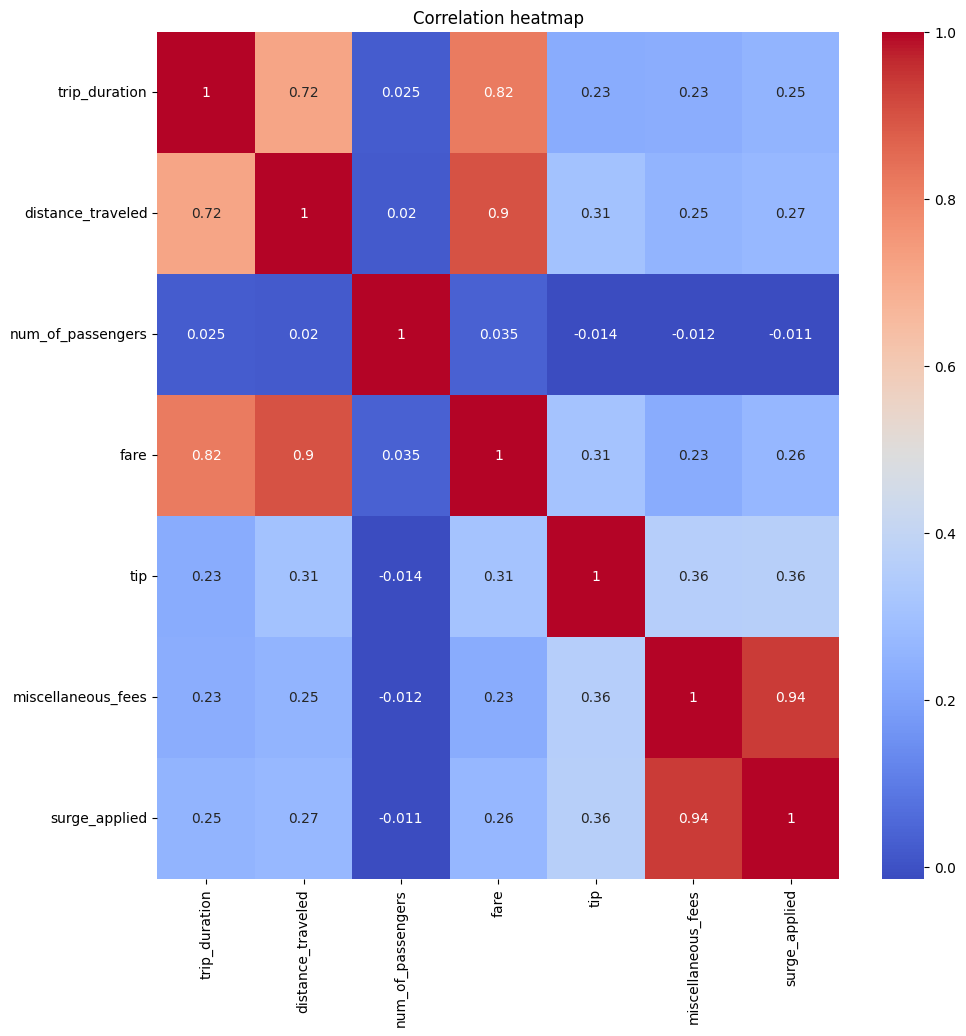

In [15]:
# Changing plot figure
plt.figure(figsize = (11, 11))
# Making the correlation heatmap
sns.heatmap(cordf, cmap = 'coolwarm', annot = True)
# Adding a title
plt.title("Correlation heatmap")
# Showing the plot
plt.show()

### Checking for feature distributions and relations between each 2 features

In [16]:
# # Creating pair plot between features
# plot = sns.PairGrid(cdf)
# # Setting diagonal plots as histogram
# plot.map_diag(sns.histplot, kde = True)
# # Settting upper plots as scatter
# plot.map_upper(sns.scatterplot)
# # Setting lower plots as kde plots
# plot.map_lower(sns.kdeplot)

## Choosing the features 'Distance Traveled' and 'Trip Duration' as they have the highest correlation with our target feature 'Fare'. Hence, showing their relationships in detail to choose the best one among them

### 3D plot

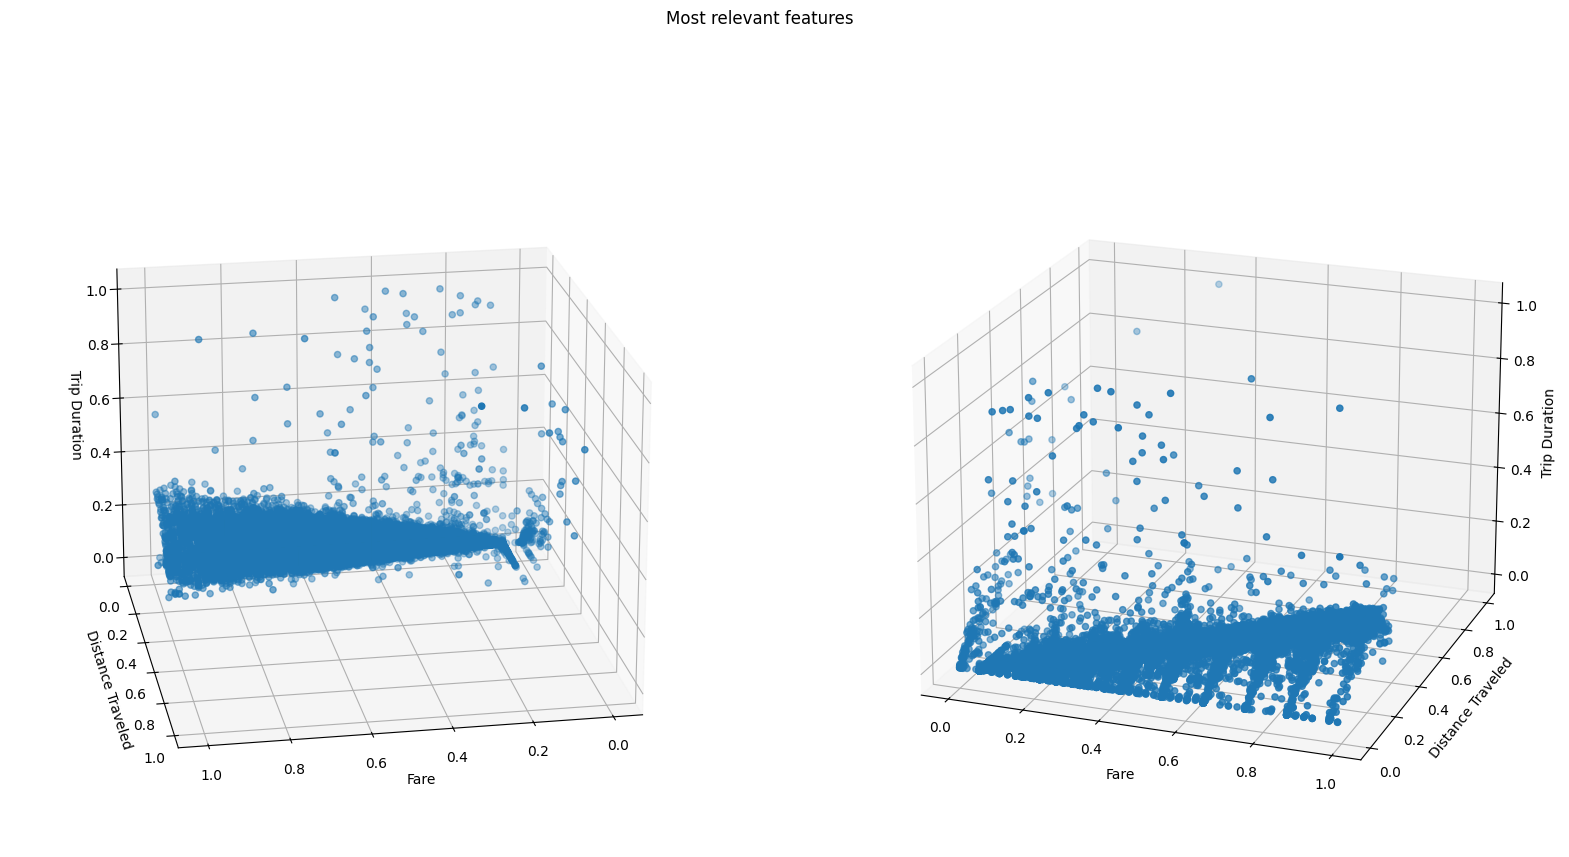

In [17]:
# Create a new figure with a specified size
fig = plt.figure(figsize=(20, 10))

# Add a subplot on the left (121) with 3D projection
ax = fig.add_subplot(121, projection='3d')

# Scatter plot for the first subplot
ax.scatter(cdf['fare'], cdf['distance_traveled'], cdf['trip_duration'])

# Set labels for the axes
ax.set_xlabel('Fare')
ax.set_ylabel('Distance Traveled')
ax.set_zlabel('Trip Duration')

# Set the viewing angle for the subplot
ax.view_init(elev=20, azim=80)

# Add a subplot on the right (122) with 3D projection
ax = fig.add_subplot(122, projection='3d')

# Scatter plot for the second subplot
ax.scatter(cdf['fare'], cdf['distance_traveled'], cdf['trip_duration'])

# Set labels for the axes
ax.set_xlabel('Fare')
ax.set_ylabel('Distance Traveled')
ax.set_zlabel('Trip Duration')

# Set the viewing angle for the subplot
ax.view_init(elev=20, azim=290)

# Set title for both plots
plt.suptitle('Most relevant features')

# Display the plot
plt.show()

### 2D plots

Text(0.5, 1.0, 'Fare and Distance Traveled')

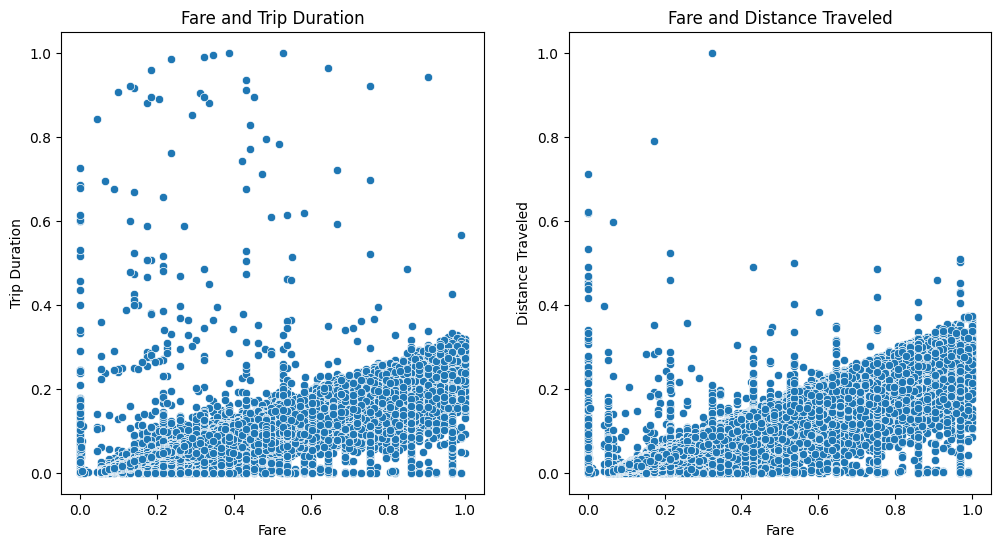

In [18]:
# Create a new figure with a specified size
plt.figure(figsize=(12, 6))

# Add a subplot on the left (121)
plt.subplot(121)

# Create a scatter plot for fare and trip duration
sns.scatterplot(data=cdf, x='fare', y='trip_duration')

# Add labels and title for the subplot
plt.xlabel('Fare')
plt.ylabel('Trip Duration')
plt.title('Fare and Trip Duration')

# Add a subplot on the right (122)
plt.subplot(122)

# Create a scatter plot for fare and distance traveled
sns.scatterplot(data=cdf, x='fare', y='distance_traveled')

# Add labels and title for the subplot
plt.xlabel('Fare')
plt.ylabel('Distance Traveled')
plt.title('Fare and Distance Traveled')

# From the previous plots we can say that the best, most expressive feature combined with 'Fare' for the creation of the clustering groups is 'Distance Traveled' 

### Taking a sample of 900 to apply the clustering algorithms on and specifying the features to be used

In [19]:
# Taking a random sample
sdf = cdf.sample(900, random_state=43)
final_sdf = final_df.sample(900, random_state=43)
# Choosing the best features for clustering
best_features = sdf[["distance_traveled" , "fare"]]

## Clustering

### K-Medoids Clustering

### Performing the clustering after finding best number of clusters

In [20]:
# Trying different possible numbers of clusters and ranking them based on silhouette score
n = list(range(2, 5))
silhouette_scores = []
for i in n:
    # Apply k-medoids clustering on each number
    kmedoids = KMedoids(i,method='alternate',init='build', random_state=42)
    kmedoids.fit(best_features)

    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(best_features, kmedoids.labels_)
    silhouette_scores.append(silhouette_avg)

# Finding which number of clusters had the highest silhouette score
highest_index = silhouette_scores.index(max(silhouette_scores))
print(f"Maximum Silhouette Score is {silhouette_scores[highest_index]} at number of clusters of {n[highest_index]}")
KMedoids_silhouette_score = silhouette_scores[highest_index]

# Apply k-medoids clustering using the best number of clusters
kmedoids = KMedoids(n[highest_index], method='alternate', init='build', random_state=42)
kmedoids.fit(best_features)

# Add labels to the dataframe
sdf['K-Medoids Clustering'] = kmedoids.labels_+1
final_sdf['K-Medoids Clustering'] = kmedoids.labels_+1
sdf

Maximum Silhouette Score is 0.6649906910438641 at number of clusters of 2


,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,surge_applied,K-Medoids Clustering
36462,0.025393,0.023813,0.25,0.139785,0.136364,0.289673,0.0,1
73016,0.082057,0.076120,0.25,0.333333,0.000000,0.130982,0.0,2
89674,0.031208,0.028094,0.25,0.161290,0.378788,0.544584,1.0,1
86612,0.020676,0.028094,0.25,0.139785,0.166667,0.129975,0.0,1
37343,0.054856,0.064482,0.25,0.268817,0.363636,0.548111,1.0,1
...,...,...,...,...,...,...,...,...
168446,0.049170,0.056187,0.50,0.236559,0.333333,0.133501,0.0,1
4303,0.060735,0.036789,0.25,0.236559,0.409091,0.121914,0.0,1
43873,0.016541,0.019130,0.25,0.107527,0.257576,0.621159,1.0,1
128222,0.062997,0.041739,0.25,0.247312,0.272727,0.140050,0.0,1


### Visualizing the result of K-Medoids Clustering using scatterplot

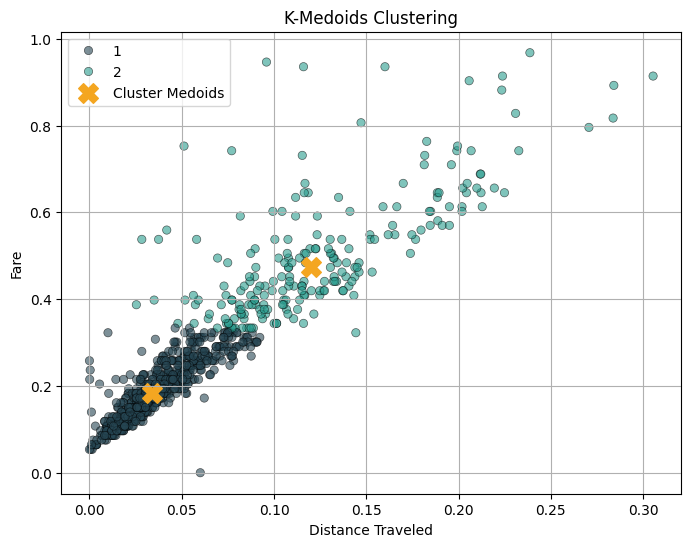

In [21]:
# Defining color palette
colors = ['#264653', '#2A9D8F']
# Create a new figure with a specified size
plt.figure(figsize=(8, 6))
# Scattering the sample points using different colors for each cluster
sns.scatterplot(x=sdf["distance_traveled"], y=sdf["fare"], hue=(kmedoids.labels_+1), palette=colors, edgecolor='k', alpha=0.6)
# Scattering the medoids on the plot
plt.scatter(kmedoids.cluster_centers_[:, 0], kmedoids.cluster_centers_[:, 1], c='#F4A621', marker='X', s=200, label='Cluster Medoids')

# Add labels, title, legend and grid for the plot
plt.title('K-Medoids Clustering')
plt.xlabel('Distance Traveled')
plt.ylabel('Fare')
plt.legend()
plt.grid(True)
plt.show()

### Hierarchical Clustering

### Performing the clustering after finding best number of clusters

In [22]:
# performing hierarchical clustering on the data sample
Z = linkage(sdf, method='ward')

# Trying different possible number of clusters and ranking them based on silhouette score
n = list(range(2, 11))
silhouette_scores = []
for i in n:
    # Extracting clusters labels from linkage matrix
    hierarchical_labels = fcluster(Z, i, criterion='maxclust')

    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(best_features, hierarchical_labels)
    silhouette_scores.append(silhouette_avg)

# Finding which number of clusters had the highest silhouette score
highest_index = silhouette_scores.index(max(silhouette_scores))
print(f"Maximum Silhouette Score is {silhouette_scores[highest_index]} at number of clusters of {n[highest_index]}")
Hierarchical_silhouette_score = silhouette_scores[highest_index]

# Extracting cluster labels from linkage matrix using the best number of clusters
hierarchical_labels = fcluster(Z, n[highest_index], criterion='maxclust')

# Add labels to the dataframe
sdf['Hierarchical Clustering'] = hierarchical_labels
final_sdf['Hierarchical Clustering'] = hierarchical_labels
sdf

Maximum Silhouette Score is 0.27697800531949024 at number of clusters of 3


,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,surge_applied,K-Medoids Clustering,Hierarchical Clustering
36462,0.025393,0.023813,0.25,0.139785,0.136364,0.289673,0.0,1,2
73016,0.082057,0.076120,0.25,0.333333,0.000000,0.130982,0.0,2,3
89674,0.031208,0.028094,0.25,0.161290,0.378788,0.544584,1.0,1,1
86612,0.020676,0.028094,0.25,0.139785,0.166667,0.129975,0.0,1,2
37343,0.054856,0.064482,0.25,0.268817,0.363636,0.548111,1.0,1,1
...,...,...,...,...,...,...,...,...,...
168446,0.049170,0.056187,0.50,0.236559,0.333333,0.133501,0.0,1,2
4303,0.060735,0.036789,0.25,0.236559,0.409091,0.121914,0.0,1,2
43873,0.016541,0.019130,0.25,0.107527,0.257576,0.621159,1.0,1,1
128222,0.062997,0.041739,0.25,0.247312,0.272727,0.140050,0.0,1,2


### Visualizing the result of Hierarchical Clustering using dendrogram

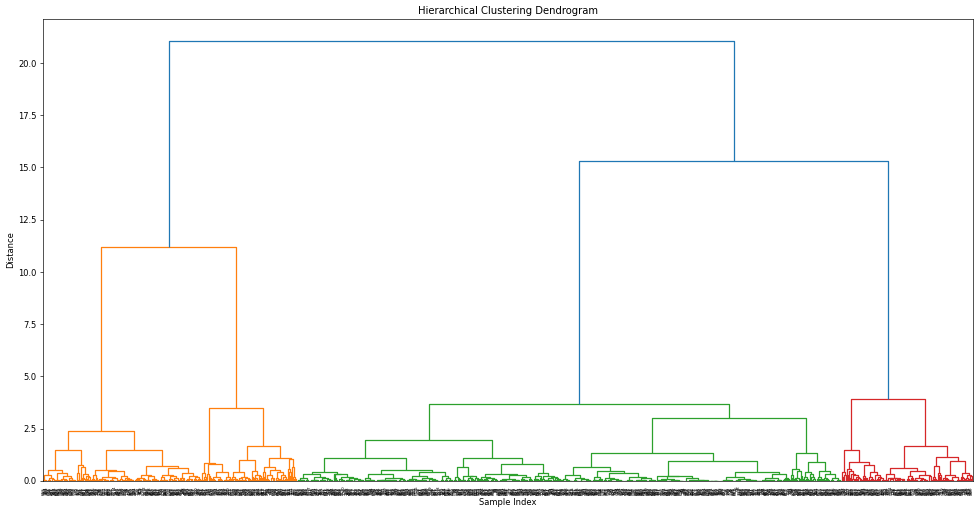

In [23]:
# Create a new figure with a specified size
plt.figure(figsize=(20, 10), dpi=60)
# creating a dendrogram for the hierarchical clustering results
dendrogram(Z)

# Add labels and title for the subplot
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

### Visualizing the result of Hierarchical Clustering using scatterplot

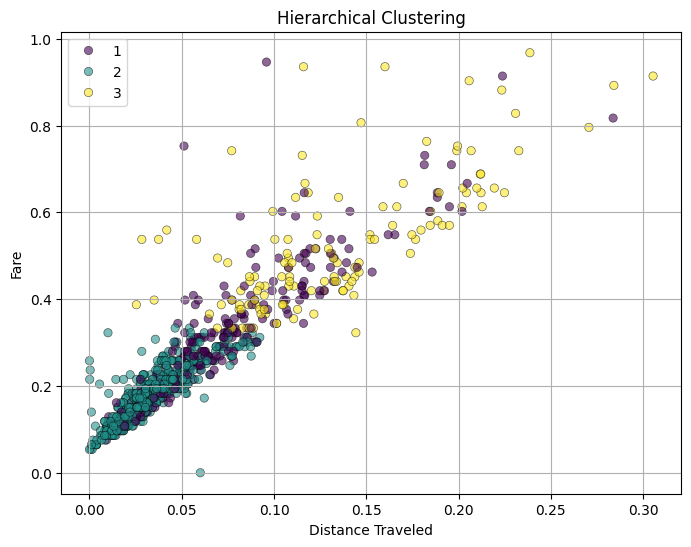

In [24]:
# Create a new figure with a specified size
plt.figure(figsize=(8, 6))
# Scattering the sample points using different colors for each cluster
sns.scatterplot(x=sdf["distance_traveled"], y=sdf["fare"], hue=hierarchical_labels, palette='viridis', edgecolor='k', alpha=0.6)

# Add labels, title, legend and grid for the plot
plt.title('Hierarchical Clustering')
plt.xlabel('Distance Traveled')
plt.ylabel('Fare')
plt.legend()
plt.grid(True)
plt.show()

### Fuzzy Clustering

### Performing the clustering after finding best number of clusters

In [25]:
# Trying different possible number of clusters and ranking them based on silhouette score
n = list(range(2, 11))
f = list(range(2,11))
e = [0.05, 0.005, 0.0005, 0.00005]
silhouette_scores = []
for i in n:
    for j in f:
        for k in e:
            # Apply fuzzy cmeans clustering
            cntr, u, u0, d, jm, p, fpc = fuzzy.cluster.cmeans(best_features.T, i, j, error=k, maxiter=1000)

            # Get cluster membership for each data point
            cluster_membership = np.argmax(u, axis=0)

            # Calculate Silhouette Score
            silhouette_avg = silhouette_score(best_features, cluster_membership)
            silhouette_scores.append(silhouette_avg)

# Finding which number of clusters had the highest silhouette score
highest_index = silhouette_scores.index(max(silhouette_scores))
print(f"Maximum Silhouette Score is {silhouette_scores[highest_index]} at number of clusters of {n[highest_index]}")
Fuzzy_silhouette_score = silhouette_scores[highest_index]

# Apply fuzzy cmeans clustering usng the best number of clusters
cntr, u, u0, d, jm, p, fpc = fuzzy.cluster.cmeans(best_features.T, n[highest_index], 2, error=0.0005, maxiter=1000)

# Get cluster membership for each data point
fuzzy_membership = np.argmax(u, axis=0)

# Add labels (membership) to the dataframe
sdf['Fuzzy Cluster'] = fuzzy_membership+1
final_sdf['Fuzzy Cluster'] = fuzzy_membership+1
sdf

Maximum Silhouette Score is 0.676684284506358 at number of clusters of 3


,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,surge_applied,K-Medoids Clustering,Hierarchical Clustering,Fuzzy Cluster
36462,0.025393,0.023813,0.25,0.139785,0.136364,0.289673,0.0,1,2,2
73016,0.082057,0.076120,0.25,0.333333,0.000000,0.130982,0.0,2,3,1
89674,0.031208,0.028094,0.25,0.161290,0.378788,0.544584,1.0,1,1,2
86612,0.020676,0.028094,0.25,0.139785,0.166667,0.129975,0.0,1,2,2
37343,0.054856,0.064482,0.25,0.268817,0.363636,0.548111,1.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
168446,0.049170,0.056187,0.50,0.236559,0.333333,0.133501,0.0,1,2,2
4303,0.060735,0.036789,0.25,0.236559,0.409091,0.121914,0.0,1,2,2
43873,0.016541,0.019130,0.25,0.107527,0.257576,0.621159,1.0,1,1,2
128222,0.062997,0.041739,0.25,0.247312,0.272727,0.140050,0.0,1,2,1


###### cntr => cluster centers
###### u => final fuzzy partition matrix
###### u0 => initial fuzzy partition matrix
###### d => distance matrix
###### jm => objective function history
###### p => probability matrix
###### fpc => fuzzy partition coefficient

### Visualizing the result of Fuzzy Clustering using scatterplot

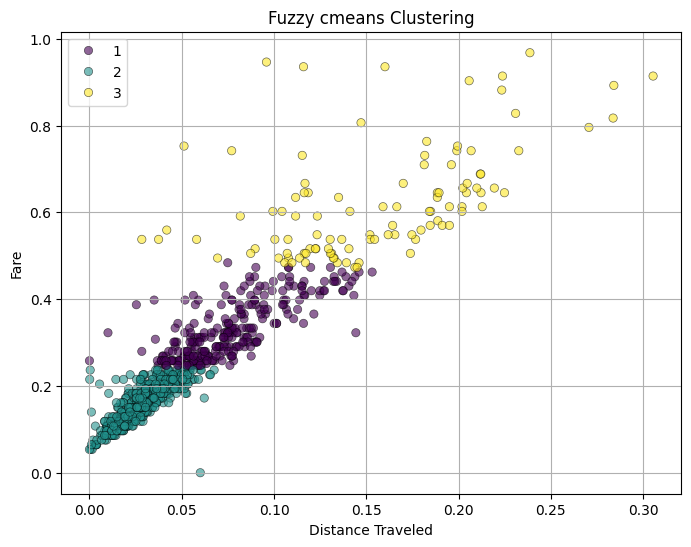

In [26]:
# Create a new figure with a specified size
plt.figure(figsize=(8, 6))
# Scattering the sample points using different colors for each cluster
sns.scatterplot(x=sdf["distance_traveled"], y=sdf["fare"], hue=(fuzzy_membership+1), palette='viridis', edgecolor='k', alpha=0.6)

# Add labels, title, legend and grid for the plot
plt.title('Fuzzy cmeans Clustering')
plt.xlabel('Distance Traveled')
plt.ylabel('Fare')
plt.legend()
plt.grid(True)
plt.show()

## Comparison between the different algorithms using Silhouette Score

### Creating the comparison series

In [27]:
# making a pandas series of each algorithm and its score
data=[KMedoids_silhouette_score, Hierarchical_silhouette_score, Fuzzy_silhouette_score]
index=['K-Medoids', 'Hierarchical', 'Fuzzy']
comparison = pd.Series(data, index=index)
comparison

K-Medoids       0.664991
Hierarchical    0.276978
Fuzzy           0.676684
dtype: float64

### Visualizing the difference between the silhouette scores across the different clustering algorithms

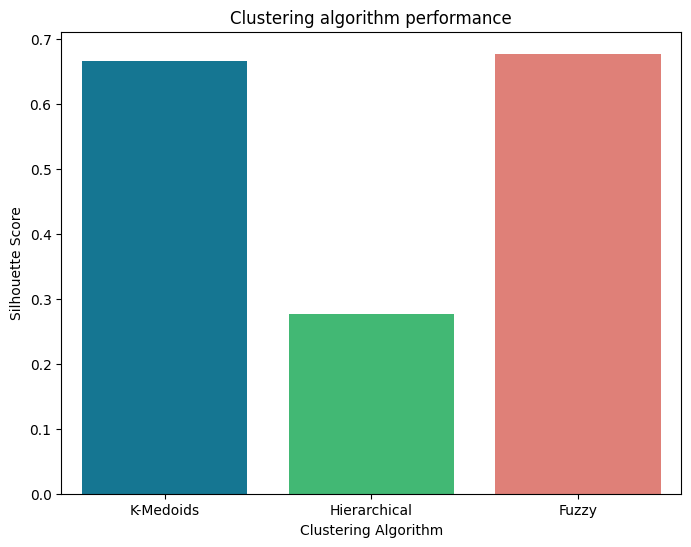

In [28]:
# Define color palette
colors = ['#0081a7', '#2ecc71', '#f07167']
# Create a new figure with a specified size
plt.figure(figsize=(8, 6))
# Plots Silhouette Score
sns.barplot(x=comparison.index, y=comparison.values, palette=colors)

# Add labels and title for the plot
plt.title('Clustering algorithm performance')
plt.xlabel('Clustering Algorithm')
plt.ylabel('Silhouette Score')
plt.show()

## Different Techniques

Different techniques were applied, out of the 3 of them, 2 produced satisfactory results, and one failed to produce any; 
The one who failed to produce decent results was the hierarchical (Agglomerative) clustering. We believe it is due to the linearity of the data that it fails to cluster it, it could however be for other underlying issues. 

The other 2 methods were able to cluster the data. one, kmedoids clustering, produced clusters that included decent similarity amongst elements of the same cluster, and high dissimilarity between elements of other clusters, however this clustering did not provide insights on the nature of the data, or any underlying patterns.

However with the other one, the fuzzy clustering, we were able to attain all the benefits from the previous method, and were able to deduce logical insights about the data and underlying patterns.

## Insights 

After careful analysis of the clustering results especially the fuzzy clustering, we find that the optimal cluster count for pattern recognition is 3.
We find that the when the data is left to cluster into 3 groups; it divides itself into 3 categories, these categories can be interpreted as follows:

- The first cluster where short trips cost a uniform amount.
- The second cluster where the distance is increased, but so is the variance in the fare paid.
- The third cluster where it seems that all the anomalies in the data have clustered into, these include high fares over minute distances, and high and medium distances with high fares. 

### Saving the final original dataframe with the clustering results

In [29]:
# Saving the original sample data with the labels
final_sdf.to_csv('clustering_results.csv', index = False)
final_sdf

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,surge_applied,K-Medoids Clustering,Hierarchical Clustering,Fuzzy Cluster
36462,393.0,1.80,1.0,48.75,9,13.875,0,1,2,2
73016,1270.0,5.71,1.0,116.25,0,6.000,0,2,3,1
89674,483.0,2.12,1.0,56.25,25,26.525,1,1,1,2
86612,320.0,2.12,1.0,48.75,11,5.950,0,1,2,2
37343,849.0,4.84,1.0,93.75,24,26.700,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
168446,761.0,4.22,2.0,82.50,22,6.125,0,1,2,2
4303,940.0,2.77,1.0,82.50,27,5.550,0,1,2,2
43873,256.0,1.45,1.0,37.50,17,30.325,1,1,1,2
128222,975.0,3.14,1.0,86.25,18,6.450,0,1,2,1
